<img src="./img/metro_madrid.jpg" alt="drawing" width="500"/>

# Transporte y renta en la Comunidad de Madrid

Este proyecto busca arrojar luz sobre los patrones de comportamiento en el transporte de los ciudadanos de la Comunidad de Madrid, estudiando posibles vínculos con su renta. Para ello, se utiliza la [Encuesta de Movilidad del Consorcio Regional](https://datos.comunidad.madrid/dataset/resultados-edm2018) de Transportes de Madrid (CRTM), realizada en el 2018.

Para los cálculos de la renta, se utilizan diferentes tablas extraídas de la [Encuesta de Condiciones de Vida](https://ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=ultiDatos&idp=1254735976608) del INE, para el año 2018

La hipótesis principal de este proyecto es que **existe una relación entre la renta y el uso del transporte en la Comunidad de Madrid**. En concreto, se buscará contrastar:
+ Si las rentas más altas eligen el coche como primera opción para desplazamientos laborales y por placer.
+ Las rentas bajas, para trabajar, utilizan más el transporte público que el coche.
+ Las mujeres utilizan más el transporte público para desplazamientos laborales, sin tener en cuenta la renta.
    + Lo que, unido al segundo punto, explicaría que las mujeres no usan más el transporte público por deseo sino por necesidad.
+ Los hombres utilizan más el transporte privado para desplazamientos por placer


### SUPUESTOS
Dados los datos utilizados, hemos de tener en cuenta varios puntos:
+ Se está utilizando la última encuesta publicada por el CRTM.
    + Sí se cuentan con los datos de uso del Metro de Madrid, que en 2023 volvieron a niveles pre-pandemia. Por tanto, podemos suponer que no han cambiado las pautas de comportamiento en un nivel agregado
+ No contamos con la renta de los encuestados. Para ello generaremos un dato *proxy*, que estimaremos en función de las condiciones socioeconómicas de los encuestados (edad, ocupación, género, grado de educación, y si cuenta con coche).
    + Renta != Riqueza. Estimaremos la cantidad de **generar** , no de **poseer**. Una persona sin trabajo pero con patrimonio no quedará reflejada en este estudio.
    + Por disponibilidad de los datos, se utilizarán las medias de las rentas. En función de disponibilidad de los datos, es posible que se recoja la media española en lugar de la de la Comunidad de Madrid.
+ Los datos sólo tienen en cuenta días estrictamente laborales (Lunes-Jueves)
+ Si bien no tiene impacto a primera vista sobre las hipótesis, se realizará un estudio de impacto de la **meteorología** sobre el uso de unos u otros medios transportes.


## ÍNDICE

1. [Obtención de los datos](#1.-obtencion-de-los-datos)
2. [Tratamiento de los datos](#2.tratamiento-de-los-datos)
3. [Análisis preliminar](#analisis-preliminar)
4. [Cálculo de renta](#4.-CÁLCULO-DE-RENTA)
5. [Hipótesis principal](#5.-HIPÓTESIS-PRINCIPAL) 

## 1. Obtención de los datos

Para este proyecto se han utilizado las siguientes fuentes:
### Consorcio Regional de Transportes de Madrid
Se ha utilizado la Encuesta de Movilidad del CRTM realizada en 2018, descargada desde [aquí](https://datos.crtm.es/search?q=edm2018). Se utilizan, en concreto, dos datasets:
+ EDM2018VIAJES: que contiene información sobre la razón por la que se desplaza el individuo, cuádo comienza, y el método de transporte prioritario.
+ EDM2018INDIVIDUOS: con información del viajero (edad, nivel de estudios, actividad...)

Estas encuestas fueron realizadas en el periodo febrero-junio de 2018.

### AEMET
Se ha descargado un histórico de la temperatura media y las precipitaciones, a lo largo del periodo en el que se realizaron las encuestas, a través de su [API](https://opendata.aemet.es/centrodedescargas/inicio)

### Instituto de Estadística de la Comunidad de Madrid
Se ha utilizado la Encuesta de Condiciones de Vida de 2019, que recoge las encuestas **del año anterior**. Están disponibles [aquí](https://www.madrid.org/iestadis/fijas/estructu/sociales/iecv19.htm)

## 2. Tratamiento de los datos

Gran parte del trabajo está encapsulado en funciones, dentro de un utils.py:

In [1]:
import pandas as pd
from utils import utils as ut

Una primera función es para la descarga de los datos de AEMET, guardándolos en una carpeta "treated" dentro de "data". De esta forma no tendremos que hacer consultas a la API cada vez que queramos trabajar con ellos:

In [2]:
#ut.retrieve_aemet()

Sólo se utilizó la primera vez pero necesita una URL que dará AEMET tras la consulta a su API. data_destination será un argumento elegible por el usuario para guardar el output, en csv.

Los datos principales se tratan en la main_data_extraction:

In [3]:
# ut.main_data_extraction("./data/raw/EDM2018INDIVIDUOS.xlsx","./data/raw/EDM2018VIAJES.xlsx",'./data/treated/aemet_weather.csv','./data/treated/transp.csv')
# df_transp = pd.read_csv("./data/treated/transp.csv")

Esta función toma tres argumentos: la encuesta de movilidad por individuos, la de los viajes, la base de datos exportada de AEMET, y un destino para el csv final elegible por el usuario.

Debido al peso de las bases de datos origen, es una función que puede tardar en ejecutarse. Por ello, sólo tratará de hacer el csv destino si no encuentra uno ya creado. Si no lo encuentra:

1. Lee como dataframes las rutas introducidas.
2. Crea un dataframe común de los tres orígenes, mediante la función `main_dfs_treat` (explicada más adelante).
3. Aplica algunas conversiones a ese dataframe común mediante la función `transp_conversion`.
4. Guarda el dataframe en un csv

In [4]:
# ut.main_dfs_treat(trip,indiv,weather)

Esta función se utiliza dentro de main_data extraction y toma tres argumentos: encuesta de individuos, encuesta de viajes, y base de datos meteorológica. 
+ Para la base de datos de **meteorología**, crea una nueva columna "datemege", que será utilizada para el merge con la final.
+ En la base de datos **individual**:
    + Crea también una "datemerge", de forma similar a la de meteorología.
    + Se mergea con la de meteorología, quedándose con la temperatura media (tmed) y las precipitaciones (prec). Esta última será la que más uso tenga en el análisis.
    + Se crea un identificador único de los individuos, concatenando el id del hogar con el del individuo.
    + Se renombran las columnas más importantes para tener un título más usable.
    + Se filtran las columnas que se consideran de mayor interés.
+ En la base de datos de **viajes**:
    + Se crean dos ids: id_indiv (tal como el creado en la individual), e id_trip (id_indiv más el id del viaje). **Hay varios viajes realizados por el mismo individuo en el mismo día**, pero se toman como relevantes para el estudio.
    + Se renombran las variables relevantes.
    + Se filtran las variables relevantes.
    + Se realiza el merge con la individual.

Por último, se tratan las variables de tmed y prec para que sean de tipo float. La función retorna el dataframe totalmente tratado, para seguir siendo utilizado por el `main_data_extraction`

In [5]:
# ut.transp_conversion(df_transp)

Se encarga de convertir gran parte de la información categórica, que se almacena como tipo entero. Renombra los valores que sean nnecesarios.

Aquí aprovechamos para agrupar algunos de las categorías: por ejemplo, 'public' serán todos los métodos de transporte de tipo público, mientras que 'car' recogerá todas sus modalidades (sea el conductor, el pasajero, compartido con un compañero de trabajo...). Esto se realiza para las columnas:
+ **transport**
+ **reason** (motivo del viaje)
+ **activity** (ocupación del individuo: si trabaja, estudia, está en paro, jubilado...)
+ **studies** (nivel de estudios del individuo)
+ **gender**
+ **week_day** (lunes-jueves)
+ Se aprovecha para crear una nueva variable categórica: **weather**. Toma 'dry' cuando prec es menor a 0.1, y 'rain' cuando es igual o mayor.

La función retorna el dataframe con todos los cambios aplicados, para seguir siendo usado por el `main_data_extraction`

In [6]:
# ut.aux_data_extraction()

Esta es la función que extrae de la Encuesta de Condiciones de Vida los datos necesarios de la renta. Toma 4 fuentes de esta:
+ Género y edad, incluidas en la misma tabla.
+ Educación
+ Ocupación

En todas ellas se realiza una **normalización** con media 1. Retorna tres dataframes, con los orígenes citados.

### Código del tratamiento

In [7]:
import pandas as pd
from utils import utils as ut

In [8]:
ut.main_data_extraction("./data/raw/EDM2018INDIVIDUOS.xlsx","./data/raw/EDM2018VIAJES.xlsx",'./data/treated/aemet_weather.csv','./data/treated/transp.csv')
df_transp = pd.read_csv("./data/treated/transp.csv")
df_gender_age, df_educ, df_occup = ut.aux_data_extraction()

Extracting data...
./data/treated/transp.csv already exists
Extracting auxiliary data...
Auxiliary data extracted


## 3.- Análisis preliminar

En general, nos encontramos con un dataframe bastante limpio, con ningún null. Además, ya hemos realizado anteriormente muchas de las transformaciones necesarias. Generamos algunos gráficos que son permitirán saber más sobre las principales variables categóricas.

In [9]:
# ut.pie_charts(pies,df)

La siguiente función crea un csv que compara el uso del transporte en días secos y de lluvia.

In [10]:
# ut.dry_rain(df_transp)

Y la siguiente función nos sirve para generar un análisis del comportamiento de los individuos en función de días secos o de lluvia:

In [11]:
# ut.weather_change(df_weather,df_weather_work)

Nos generará dos gráfiicos de barras: diferencia de usos del transporte en general; y diferencia para los viajes por trabajo, en lo que se basará la hipótesis principal.


### Código del análisis

In [12]:
df_transp.head()

,id_indiv,id_trip,start_trip,transport,freq,reason,distance,trip_pond,gender,age,...,activity,day,month,year,week_day,datemerge,tmed,prec,weather,income
0,1891,18911,800,car,1,work,6.660582,66.304668,male,28,...,worker,25,April,2018,wednesday,2018-4-25,20.8,0.0,dry,167.75
1,1891,18912,1800,car,1,work,6.660582,66.304668,male,28,...,worker,25,April,2018,wednesday,2018-4-25,20.8,0.0,dry,167.75
2,2441,24411,800,car,1,work,6.586497,66.304668,male,36,...,worker,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,240.75
3,2441,24412,1800,car,1,work,6.586497,66.304668,male,36,...,worker,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,240.75
4,2442,24421,1113,walking,1,shopping,0.203441,69.473571,female,35,...,jobless,26,April,2018,thursday,2018-4-26,20.2,0.0,dry,153.75


In [13]:
df_transp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222672 entries, 0 to 222671
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_indiv    222672 non-null  int64  
 1   id_trip     222672 non-null  int64  
 2   start_trip  222672 non-null  int64  
 3   transport   222672 non-null  object 
 4   freq        222672 non-null  int64  
 5   reason      222672 non-null  object 
 6   distance    222672 non-null  float64
 7   trip_pond   222672 non-null  float64
 8   gender      222672 non-null  object 
 9   age         222672 non-null  int64  
 10  spanish     222672 non-null  int64  
 11  studies     222672 non-null  object 
 12  activity    222672 non-null  object 
 13  day         222672 non-null  int64  
 14  month       222672 non-null  object 
 15  year        222672 non-null  int64  
 16  week_day    222672 non-null  object 
 17  datemerge   222672 non-null  object 
 18  tmed        222672 non-null  float64
 19  prec   

223 filas, con muy pocos nulls

In [14]:
df_transp.describe(include='all')

,id_indiv,id_trip,start_trip,transport,freq,reason,distance,trip_pond,gender,age,...,activity,day,month,year,week_day,datemerge,tmed,prec,weather,income
count,2.226720e+05,2.226720e+05,222672.000000,222672,222672.000000,222672,222672.000000,222672.000000,222672,222672.000000,...,222672,222672.000000,222672,222672.0,222672,222672,222672.000000,222672.000000,222672,222672.000000
unique,NaN,NaN,NaN,4,NaN,6,NaN,NaN,2,NaN,...,5,NaN,5,NaN,4,67,NaN,NaN,2,NaN
top,NaN,NaN,NaN,car,NaN,work,NaN,NaN,female,NaN,...,worker,NaN,April,NaN,thursday,2018-5-10,NaN,NaN,dry,NaN
freq,NaN,NaN,NaN,88861,NaN,61806,NaN,NaN,121144,NaN,...,106061,NaN,66747,NaN,67316,6423,NaN,NaN,128978,NaN
mean,2.628231e+07,2.710087e+08,1383.160725,NaN,1.915944,NaN,7.344174,71.152602,NaN,44.569272,...,NaN,15.827073,NaN,2018.0,NaN,NaN,13.155673,3.306013,NaN,232.280894
std,1.146058e+07,1.937172e+08,450.386521,NaN,1.208929,NaN,57.466740,43.856310,NaN,20.117328,...,NaN,8.210610,NaN,0.0,NaN,NaN,5.261546,6.864867,NaN,71.392997
min,1.891000e+03,1.891100e+04,0.000000,NaN,1.000000,NaN,0.000000,2.611298,NaN,4.000000,...,NaN,1.000000,NaN,2018.0,NaN,NaN,3.000000,0.000000,NaN,96.250000
25%,1.841784e+07,1.843761e+08,935.000000,NaN,1.000000,NaN,0.650814,50.881669,NaN,29.000000,...,NaN,9.000000,NaN,2018.0,NaN,NaN,8.200000,0.000000,NaN,190.000000
50%,3.151110e+07,3.151714e+08,1400.000000,NaN,1.000000,NaN,2.115702,62.468900,NaN,47.000000,...,NaN,16.000000,NaN,2018.0,NaN,NaN,14.400000,0.000000,NaN,245.250000
75%,3.469703e+07,3.471157e+08,1753.000000,NaN,3.000000,NaN,7.630491,78.678446,NaN,59.000000,...,NaN,22.000000,NaN,2018.0,NaN,NaN,18.400000,2.600000,NaN,289.750000


Mostremos de forma gráfica las principales variables sobre las que trabajaremos:

Generating pie charts...


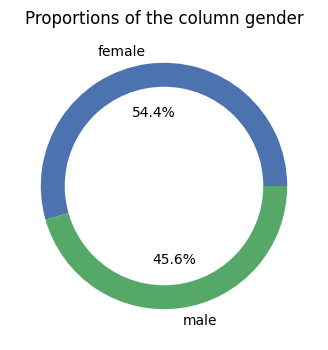

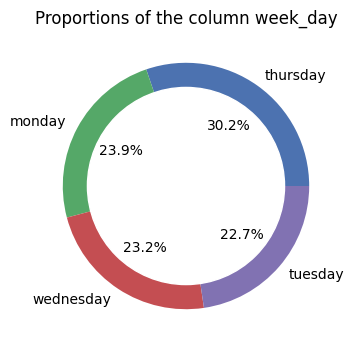

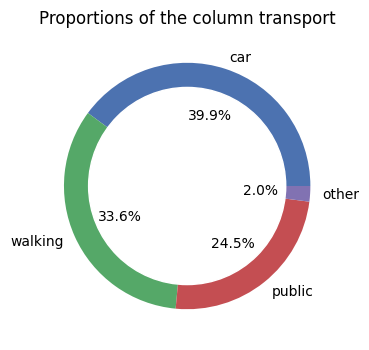

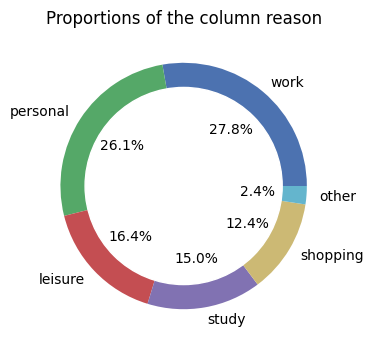

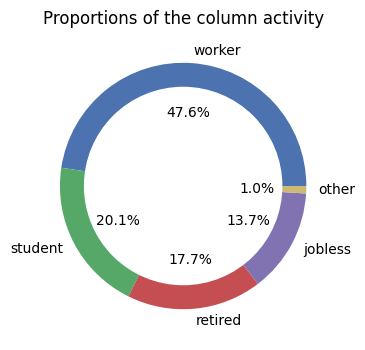

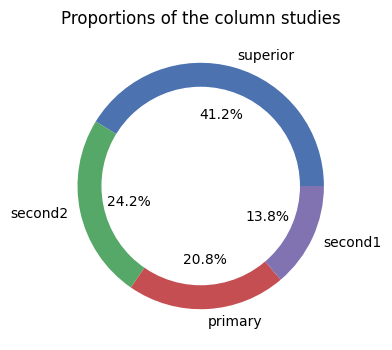

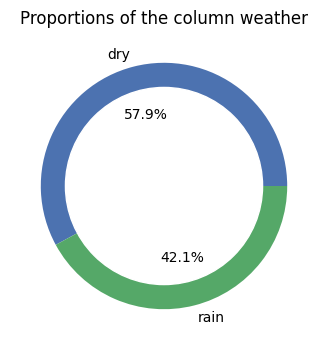

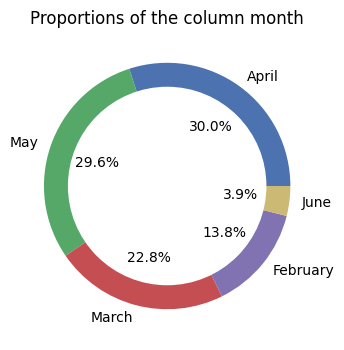

Pie charts generated in /img/plots/pies
Generating dry/rain comparison
Dry/rain comparison saved on data/output


In [15]:
ut.pie_charts(['gender','week_day','transport','reason','activity','studies','weather','month'],df_transp)
ut.dry_rain(df_transp)

Con weather_change vemos el cambio en los patrones de uso del transporte cuando llueve, en puntos porcentuales. Veremos que no hay grandes diferencias, sobre todo en los viajes por trabajo. Sin embargo, para demostrar la hipótesis principal partiremos en un principio de los **días secos**, ya que tenemos una muestra lo suficientemente grande para minimizar impacto.

Plotting weather comparison...


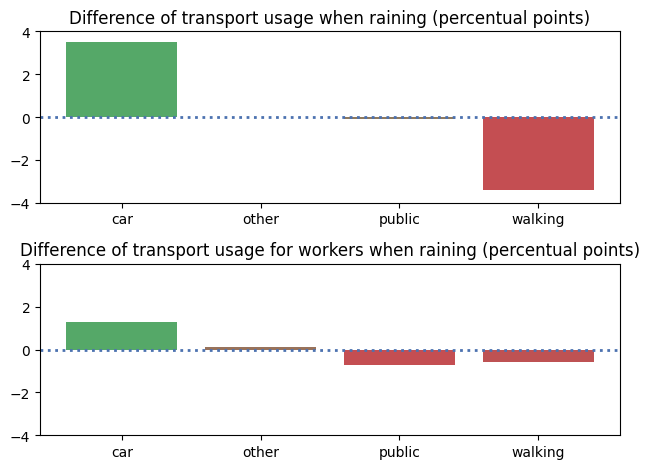

Weather comparison plotted and saved in img/plots/bars/transport_change_weather.png


In [16]:
df_weather = pd.read_csv("./data/output/weather.csv")
df_weather_work = pd.read_csv("./data/output/weather_work.csv")
ut.weather_change(df_weather,df_weather_work)

## 4. Cálculo de renta 

Una variable crítica en probar la hipótesis principal es la de los ingresos o **renta** de los viajeros. Esta no viene dada en la Encuesta de Movilidad. Por ello, crearemos un indicador de **renta esperada**, en función de las condiciones socioeconómicas que conocemos de los viajeros. Haremos uso de la función `income assign`:

In [17]:
# ut.income_assign(df_main,df_educ,df_occup,df_gender_age)

Todos los viajeros parten de un **income** (renta) de 100. A partir de ahí se le suman 25 puntos por cada uno de los cuatro indicadores, multiplicado por los resultados normalizados con media 1 generados por el aux_data_extraction:
+ **Educación** (4 categorías)

In [33]:
df_educ

1
Educación primaria o inferior    0.27
Educación secundaria 1ª etapa    0.55
Educación secundaria 2ª etapa    0.70
Educación superior               2.48
Name: 2, dtype: float64

+ **Género** (2 categorías) y **Edad** (5 categorías)

In [35]:
df_gender_age

,men,women
1,,
Menos de 16 años,-0.18,-0.36
De 16 a 29 años,0.17,-0.04
De 30 a 44 años,1.63,0.83
De 45 a 64 años,2.61,2.11
65 años o más,1.65,1.57


+ **Actividad** (5 categorías)

In [34]:
df_occup

1
Ocupados           1.67
Parados           -0.06
Jubilados          2.02
Otros inactivos    0.37
Name: 2, dtype: float64

Ello quiere decir que podremos tener hasta 4x5x2x5 = **200 rentas únicas**. Esto marcará gran parte del análisis de nuestra primera hipótesis.

La función retorna un dataframe completo, con este nuevo indicador imputado en una columna nueva. Recalcamos que este es un indicador de la renta **esperada**, dados los datos socioeconómicos que conocemos de los viajeros. Además, se han utilizado pesos relativamente arbitrarios para su creación. Sería necesario un mayor conocimiento de los encuestados y una investigación más profunda sobre los determinantes socioeconómicos de la renta.

La siguiente función nos genera un histograma que nos ayudará a entender la distribución de esta nueva columna:

In [18]:
# ut.income_dist(df_transp)

### Código de renta y análisis 

Assigning income...
Income assigned and updated in ./data/treated/transp.csv
Plotting income distribution...


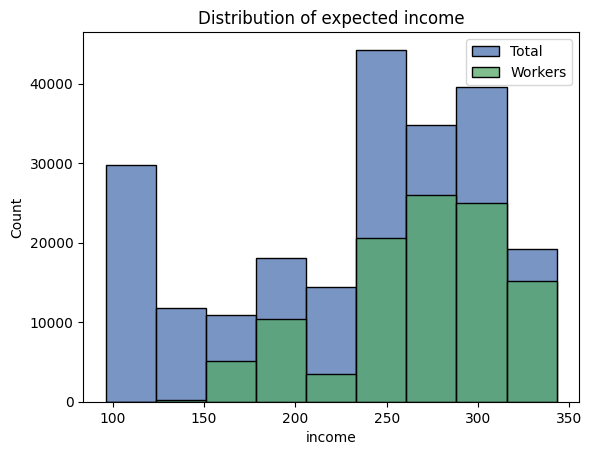

Plotting distribution finished


In [19]:
df_transp = ut.income_assign(df_transp,df_educ,df_occup,df_gender_age)
ut.income_dist(df_transp)

Podemos ver que, si bien hay más valores bajos en total, cuando nos centramos en los trabajadores comprobamos que el grueso de los ingresos se encuentra entre los 240-340. Esto es normal, ya que ser trabajador es un condicionante en el cálculo de la renta.

Fijémonos también en que podemos tener valores menores a 100: la normalización de los condicionantes, pese a tener media 1, no evita en algunos casos que estos queden por debajo del valor base de la renta.

In [20]:
df_transp['income'].nunique()

122

In [21]:
df_transp[df_transp['activity'] == "worker"]['income'].nunique()

37

Si bien el máximo de valores únicos para income era 200, tenemos sólo **122**. Tiene sentido, ya que algunas de las condiciones no iban a tener cruces reales (por ejemplo, jubilados menores de 16 años.)

Y de hecho, al centrarnos en los trabajadores, conseguiremos sólo **37 valores únicos de income**.

## 5. Hipótesis principal 

El gran objetivo de este trabajo es buscar una relación entre la **renta** y los métodos de **transporte** utilizados por los viajeros. Para ello, utilizaremos la función hypo_1

In [22]:
# ut.hypo_1(df_filtered, col_compare, title_name,file_name, jitter = False, n_obs = True, compare = 'no')

Que nos creará diferentes box plots en función de nuestras necesidades, cuyos colores reflejarán la mediana de cada uno de los grupos (si no hay comparación de varios). Argumentos:
+ df_filtered: Dataframe con los datos filtrados (o no).
+ compare: Si queremos añadir una variable categórica adicional al gráfico
+ col_compare: Qué variable categórica adicional al gráfico queremos añadir.
+ title_name: Nombre del gráfico.
+ file_name: Nombre del gráfico generado.
+ jitter: Si queremos que nos muestre las observaciones como puntos en el gráfico.
+ n_obs: Si queremos que nos añada el tamaño de la muestra para cada categoría (sólo si compare es falso)

Plotting charts for hypothesis 1...
Hypothesis 1 plotted


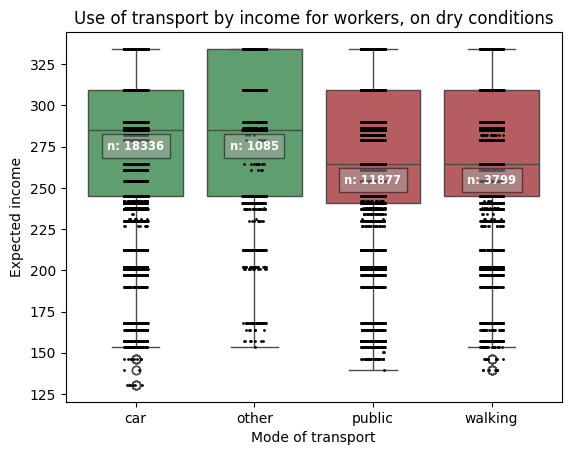

In [23]:
### Comparación de transportes, día seco, razón trabajo:
df_transp_dry_work = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work")]
ut.hypo_1(df_transp_dry_work,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=True,n_obs=True)

Vemos que hay muchos transportes con poco peso en la muestra. Nos centramos de ahora en adelante en car, public y walking:

Plotting charts for hypothesis 1...
Hypothesis 1 plotted
Plotting charts for hypothesis 1...
Hypothesis 1 plotted


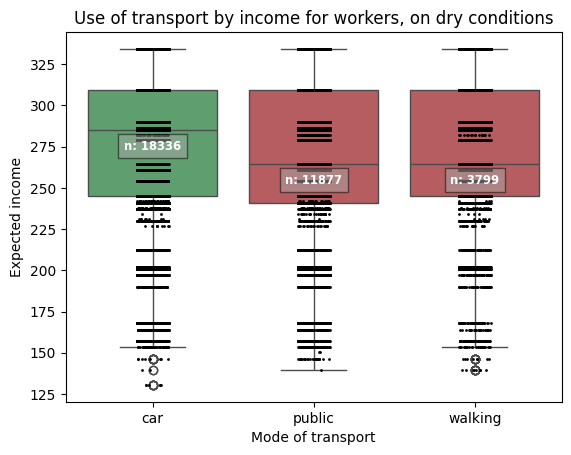

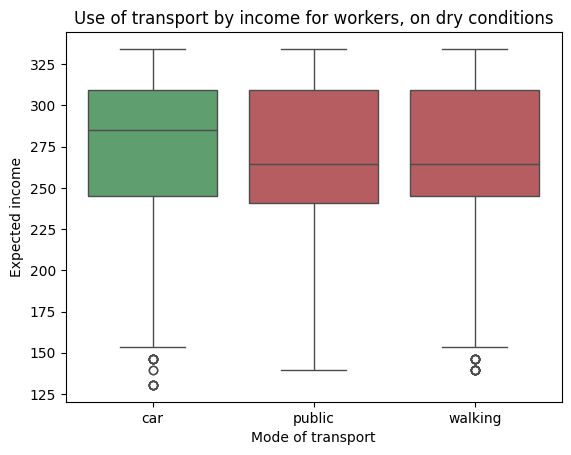

In [24]:
### Comparación de los principales transportes, día seco, razón trabajo:
df_transp_dry_work_main = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_dry_work_main,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=True,n_obs=True)
### Comparación de los principales transportes, día seco, razón trabajo, sin jitter:
df_transp_dry_work_main = df_transp[(df_transp["weather"] == "dry") & (df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_dry_work_main,title_name="Use of transport by income for workers, on dry conditions",
          file_name="transport_income_workers_main",jitter=False,n_obs=False)

Como podemos percibir, **la mediana de car es superior a public**. Sorprende también que la mediana de walking sea tan baja. Podemos ver, sin embargo, que todos los boxplots tienen cuartiles 1 y 3 similares. Esto puede explicarse por las dos razones que hemos comprobado en la generación de income:
+ Los trabajadores cuentan con una **gran concentración** en los valores de la renta, entre 240 y 340.
+ Contamos sólo con **37** valores únicos. 

¿Puede la decisión de haber dejado fuera los días lluviosos incidir sobre el resultado?

Plotting charts for hypothesis 1...
Hypothesis 1 plotted


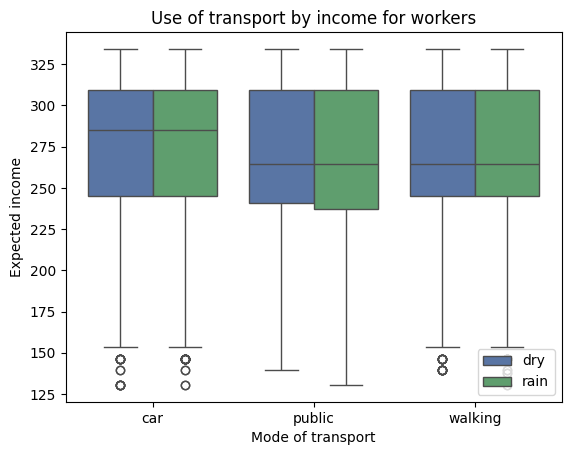

In [25]:
### Comparación de los principales transportes, día seco, razón trabajo, sin jitter:
df_transp_work_main = df_transp[(df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1(df_transp_work_main,title_name="Use of transport by income for workers",
          file_name="transport_income_workers",compare=True,col_compare='weather',jitter=False,n_obs=False)

Los valores se mantienen. De hecho, el primer cuartil de public desciende, lo que indica que precisamente rentas más bajas utilizan el transporte público cuando llueve

Por lo tanto, **podemos afirmar que sí hay una relación aparente entre la elección de transporte de los trabajadores, y su renta esperada en función de sus condiciones socioeconómicas**.

De nuevo, avisamos sobre la relativa **simpleza a la hora de generar la columna income**. Mayor análisis sería necesario para establecer una vinculación más fuerte.

## 5. Hipótesis secundarias

La segunda hipótesis del proyecto es: ¿utilizan las mujeres más el transporte público que los hombres? Esta hipótesis a priori simple esconde más enjundia de lo que parece a simple vista. Utilizamos la función hypo_2, que nos agrupa los datos como los necesitamos y nos genera un gráfico de barras para verlo:

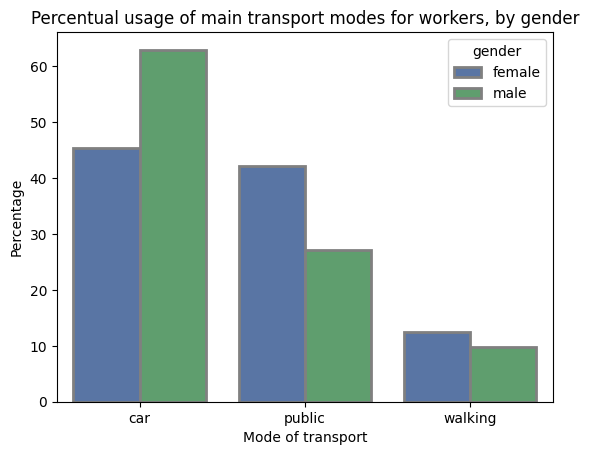

In [26]:
ut.hypo_2(df_transp)

La diferencia es abismal: **sin tener en cuenta la renta**, las mujeres trabajadoras utilizan casi en misma proporción el coche y el transporte público, mientras que los hombres utilizan el coche sobre el transporte público por más de 30 puntos porcentuales.

**¿Puede el género explicar la diferencia de uso de transporte, sin tener en cuenta la renta?**

Reutilizamos el hypo_1, esta vez comparando boxplots por género:

Plotting charts for hypothesis 1a...
Hypothesis 1 plotted


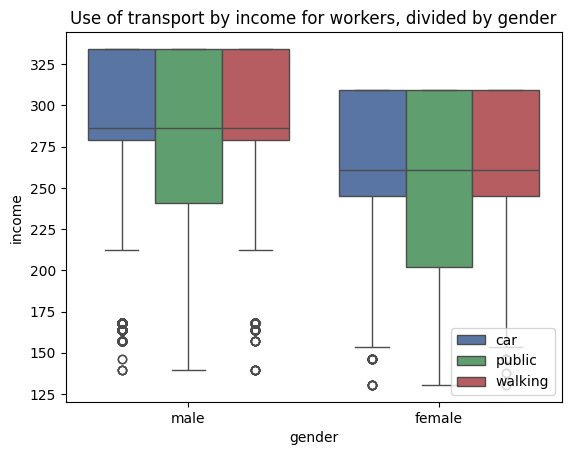

In [27]:
df_transp_work_main = df_transp[(df_transp["reason"] == "work") & (df_transp["transport"].isin(["car","public","walking"]))]
ut.hypo_1a(df_transp_work_main,title_name="Use of transport by income for workers, divided by gender",
          file_name="transport_income_workers_gender",compare=True,col_compare='transport',jitter=False,n_obs=False)

El resultado es curioso. Nos encontramos con que, cuando dividimos por género, las medianas son las mismas independientemente del transporte utilizado. Sin embargo, sí vemos variaciones en los cuartiles 1 y 2 del uso del transporte público respecto a los demás. Podemos concluir que, pese al género, **sí parece haber una diferencia de uso de transporte en función de la renta**

Por último: ¿qué ocurre si abrimos el abanico a toda la población, no solo a la trabajadora?

Plotting charts for hypothesis 1a...
Hypothesis 1 plotted


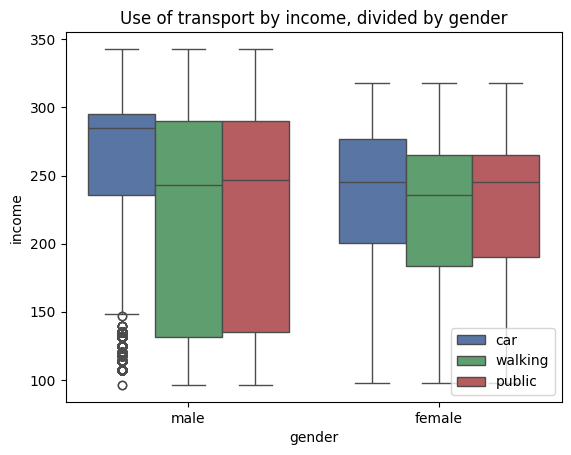

In [43]:
df_transp_work_main = df_transp[df_transp["transport"].isin(["car","public","walking"])]
ut.hypo_1a(df_transp_work_main,title_name="Use of transport by income, divided by gender",
          file_name="transport_main_gender",compare=True,col_compare='transport',jitter=False,n_obs=False)

Podemos comprobar que, en general, sí vemos un uso mayor por parte de las rentas altas del coche. Éste es más acuciante en los hombres, si bien el uso por parte de las mujeres con rentas altas es ligeramente superior también respecto al del transporte público.